### Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from helpers import helpfunction as helper
from helpers import plot_class
from helpers import plot_dicts_nue
from helpers import plot_dicts_numu
import seaborn as sns
from matplotlib import colors
from matplotlib.colors import LogNorm
import gc

In [2]:
plt.rcParams.update({'axes.titlesize': 'medium'})

In [3]:
# should return resolution per bin
per1 = 50 - 45  # 68.27/2            # 1sigma stat boundaries
per2 = 50 + 45  # 68.27/2
per21 = 50 - 95.45 / 2
per22 = 50 + 95.45 / 2
persig1 = 50 - 68.27 / 2
persig2 = 50 + 68.27 / 2


def getResolution(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    percentiles_arr = []

    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x  # / data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi
    for i in range(1, len(x_edges)):
        ax.hist(
            data_diff[bin_id == i],
            bins=50,
            range=np.percentile(data_diff, [per21, per22]),
            histtype="step",
        )
        percentiles = np.percentile(
            data_diff[bin_id == i], [per1, persig1, 50, persig2, per2]
        )
        print(
            round(10 * mids[i - 1]) / 10,
            "\t",
            np.median(data_y[bin_id == i]),
            "\t",
            percentiles[[1, 2, 3]],
            "\t",
            (percentiles[3] - percentiles[1]) / 2,
        )
        if periodic:
            percentiles /= 180 / np.pi
            mean.append(mids[i - 1] / (180 / np.pi) + percentiles[2])
        else:
            mean.append(mids[i - 1] + percentiles[2])
        err.append([percentiles[2] - percentiles[1], percentiles[3] - percentiles[2]])
        percentiles_arr.append(percentiles)
    if periodic:
        mids /= 180 / np.pi
    quants = np.array(percentiles_arr).T
    return mids, mean, err, quants


def cosmic_angles(mom_x, mom_y, mom_z):
    theta = np.arctan2(np.sqrt(np.square(mom_x) + np.square(mom_y)), mom_z)
    phi = np.arctan2(mom_y, mom_x)
    return [theta, phi]

In [4]:
input_dir = "./input/July2020/lite/"
output_dir = "./output/nue/truth/"

In [5]:
title = "MicroBooNE Simulation, Preliminary"

In [6]:
mass_p = helper.mass_p

In [7]:
keys_true = [
    "nu_pdg",
    "nu_e",
    "lep_e",
    "interaction",
    "weightSplineTimesTune",
    "n_pfps",
    "nu_completeness_from_pfp",
    "nu_purity_from_pfp",
    "event_scale",
    "nueccinc",
    "true_category",
    "true_fid_vol"
]

In [8]:
data = pd.read_pickle(input_dir + "after_training.pckl")

In [9]:
data["nu"]["mc"].keys()

dict_keys(['npion', 'weightSplineTimesTune', 'ccnc', 'interaction', 'mc_E', 'knobVecFFCCQEup', 'knobCCMECdn', 'nu_completeness_from_pfp', 'nu_purity_from_pfp', 'knobDecayAngMECup', 'theta', 'knobThetaDelta2Npiup', 'leeweight', 'lep_e', 'nu_e', 'knobThetaDelta2Npidn', 'true_nu_vtx_y', 'nu_pdg', 'knobDecayAngMECdn', 'mc_pdg', 'weightSpline', 'knobCCMECup', 'nmuon', 'slpdg', 'npi0', 'knobVecFFCCQEdn', 'true_nu_vtx_z', 'nproton', 'knobRPAup', 'knobAxFFCCQEdn', 'n_pfps', 'true_nu_vtx_x', 'knobRPAdn', 'knobAxFFCCQEup', 'nelec', 'true_fid_vol', 'nueccinc', 'Run', 'sample', 'filter', 'optical_filter', 'pdg12_broadcast', 'pdg14_broadcast', 'weightsFlux', 'weightsGenie', 'weightsReint', 'event_scale', 'weightSplineTimesTune_pi0scaled', 'true_category'])

In [10]:
highest_proton_energy = (
    (data["nu"]["mc"]["mc_pdg"] == 2212) * data["nu"]["mc"]["mc_E"]
).max()

In [11]:
nu_mc = pd.DataFrame({k: data["nu"]["mc"][k] for k in keys_true})
nu_frame = data["nu"]["daughters"]

In [12]:
del data
gc.collect()

118

In [13]:
nu_mc["scale"] = nu_mc["weightSplineTimesTune"] * nu_mc["event_scale"]
nu_frame["scale"] = nu_frame["weightSplineTimesTune"] * nu_frame["event_scale"] 

In [14]:
fields = list(nu_frame.keys())
[f for f in fields if "scale" in f]

['event_scale', 'weightSplineTimesTune_pi0scaled', 'scale']

In [15]:
# fraction of neutrino events that is nue charged current
# error, this should be 0.48
nu_mc.query("4>true_category>0")["scale"].sum() / (
    nu_mc.query("true_fid_vol")["scale"].sum()
) * 100

0.4814316238615249

In [16]:
cats_all = {r"$\nu_e$ CC ": [1, 2, 3], r"$\nu_\mu$ CC ": [4, 5, 6]}
c_labs = [r"0p0$\pi$", r"Np0$\pi$ (N>0)", r"NpM$\pi$ (M>0)"]
field = "nu_e"
weight = "scale"

### Plots

$\nu_e$ CC  [1, 2, 3]
1 0p0$\pi$
2 Np0$\pi$ (N>0)
3 NpM$\pi$ (M>0)
$\nu_\mu$ CC  [4, 5, 6]
4 0p0$\pi$
5 Np0$\pi$ (N>0)
6 NpM$\pi$ (M>0)
$\nu_e$ CC : 84.0%
$\nu_\mu$ CC : 83.5%


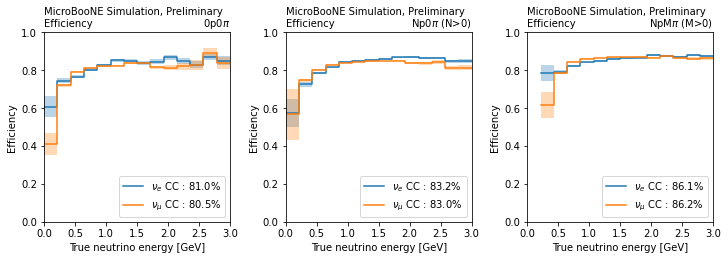

In [17]:
# Slice ID efficiecny
q_s = "n_pfps>0"
x_min = 0
x_max = 3
n_bins = 15

fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5), constrained_layout=True)

for s_lab, cats in cats_all.items():
    print(s_lab, cats)
    for cat, c_lab, ax in zip(cats, c_labs, axes):
        print(cat, c_lab)
        num = nu_mc.query(q_s).query("true_category==@cat")[field]
        den = nu_mc.query("true_category==@cat")[field]
        num_w = nu_mc.query(q_s).query("true_category==@cat")[weight]
        den_w = nu_mc.query("true_category==@cat")[weight]
        #print(len(num))
        #print(len(den))

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        #print(eff)
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0}: {1:.1%}".format(s_lab, sum(num_w) / sum(den_w)),
        )
        ax.set_title(c_lab, loc="right")
        ax.set_title(title+"\nEfficiency", loc="left")
        ax.set_xlabel("True neutrino energy [GeV]")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1)
        ax.set_xlim(x_min, x_max)
        ax.legend(loc="lower right")

fig.savefig(output_dir + "sliceID_eff.pdf", bbox_inches="tight")

# Overall performance
for s_lab, cats in cats_all.items():
    print(
        "{0}: {1:.1%}".format(
            s_lab,
            sum(nu_mc.query("true_category in @cats").query(q_s)[weight])
            / sum(nu_mc.query("true_category in @cats")[weight]),
        )
    )

In [20]:
electrons = nu_frame.query(
    "abs(backtracked_e)>0.1 & abs(backtracked_pdg)==11 & e_candidate & preselect"
)
photons = nu_frame.query(
    "abs(backtracked_e)>0.1 & abs(backtracked_pdg)==22 & e_candidate & preselect"
)

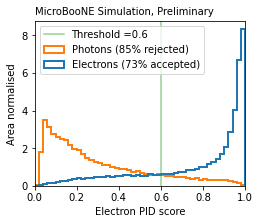

In [21]:
cut = 0.6
e_pass = electrons.query("score>@cut")[weight].sum() / electrons[weight].sum()
g_pass = photons.query("score>@cut")[weight].sum() / photons[weight].sum()

fig, ax = plt.subplots(figsize=(3.5, 3), constrained_layout=True)

ax.axvline(x=cut, label="Threshold =" + str(cut), color="C2", alpha=0.5)
ax.hist(
    [electrons["score"], photons["score"]],
    label=[
        "Electrons ({:.0%} accepted)".format(e_pass),
        "Photons ({:.0%} rejected)".format(1 - g_pass),
    ],
    range=(0, 1),
    bins=50,
    histtype="step",
    lw=2,
    density=True,
)
ax.legend(loc="upper left")
ax.set_title(title, loc="left")
ax.set_xlabel("Electron PID score")
ax.set_ylabel("Area normalised")
ax.set_xlim(0, 1)

fig.savefig(output_dir + "e_gamma_sep.pdf", bbox_inches="tight")

In [22]:
# Everything below here is electron neutrino specific

In [23]:
nue_mc = nu_mc.query("nueccinc")
nue_frame = nu_frame.query("nueccinc")

num_w_h [ 1.0246679 11.695356  19.352322  19.58786   16.520992  15.087738
 13.754654  10.911255   9.277649   7.6286316  6.257019   4.7389984
  4.0686035  2.673874 ]
den_w_h [  1.5023341  31.43393    97.668594  134.00748   147.10599   148.24078
 139.67578   121.5119    108.384155   86.48511    74.32001    62.44458
  48.713867   36.88611  ]
num_w_h [ 0.47766525 19.053085   64.043625   85.64507    88.353424   81.88187
 70.41284    55.34903    44.800323   32.689728   25.974243   20.81842
 14.987549   10.7248535 ]
den_w_h [  1.5023341  31.43393    97.668594  134.00748   147.10599   148.24078
 139.67578   121.5119    108.384155   86.48511    74.32001    62.44458
  48.713867   36.88611  ]
num_w_h [ 0.         0.6856805 11.995781  26.10989   38.435623  47.073563
 53.16884   50.787918  52.476746  45.401062  41.700775  36.52487
 29.29538   23.119507 ]
den_w_h [  1.5023341  31.43393    97.668594  134.00748   147.10599   148.24078
 139.67578   121.5119    108.384155   86.48511    74.32001    62.44

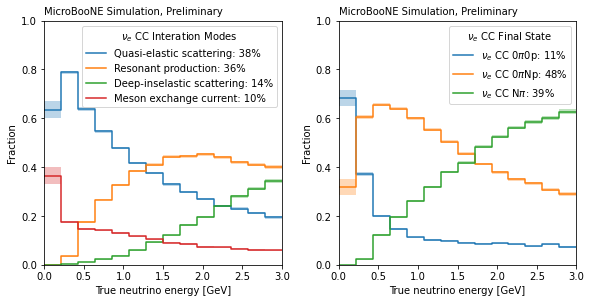

In [24]:
x_min = 0
x_max = 3
n_bins = 15

fig, axes = plt.subplots(ncols=2, figsize=(8.1, 4.1), constrained_layout=True, sharex=True)

axes = axes[::-1]
sel_field = ["true_category", "interaction"]
cats_arr = [{1: 10, 2: 11, 3: 1}, {0: 0, 1: 1, 2: 2, 10: 10}]
lab_dict = [plot_dicts_nue.category_labels, plot_dicts_nue.int_labels]
titles = ["Final State", "Interation Modes"]

for ax, cats, sel, lab_d, leg_t in zip(axes, cats_arr, sel_field, lab_dict, titles):
    for cat, cat_d in cats.items():
        den = nue_mc[field]
        num = nue_mc[field][nue_mc[sel] == cat]

        den_w = nue_mc[weight]
        num_w = nue_mc[weight][nue_mc[sel] == cat]

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0}: {1:.0f}%".format(lab_d[cat_d], sum(num_w) / sum(den_w) * 100),
        )
    ax.set_title(title, loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Fraction")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc="upper right", title=r"$\nu_e$ CC " + leg_t)

fig.savefig(output_dir + "truth_channels_modes.pdf", bbox_inches="tight")

num_w_h [ 0.30817106  5.8706455  11.233216   12.803684   11.373154   10.996017
  9.909515    7.7133904   6.6114807   5.517273    4.5925903   3.3827972
  3.1362152   2.003479  ]
den_w_h [ 1.0246679 11.695356  19.352322  19.58786   16.520992  15.087738
 13.754654  10.911255   9.277649   7.6286316  6.257019   4.7389984
  4.0686035  2.673874 ]
num_w_h [ 0.13867694  8.590295   32.73661    48.39172    54.086227   53.03055
 48.098907   39.18901    32.89966    24.52478    19.449097   15.788452
 11.297241    7.998047  ]
den_w_h [ 0.47766525 19.053085   64.043625   85.64507    88.353424   81.88187
 70.41284    55.34903    44.800323   32.689728   25.974243   20.81842
 14.987549   10.7248535 ]
num_w_h [ 0.          0.26964962  5.747378   13.659918   21.503525   27.779003
 31.50856    31.369858   33.38875    29.420319   27.640305   23.980103
 19.560669   15.534668  ]
den_w_h [ 0.         0.6856805 11.995781  26.10989   38.435623  47.073563
 53.16884   50.787918  52.476746  45.401062  41.700775  36.

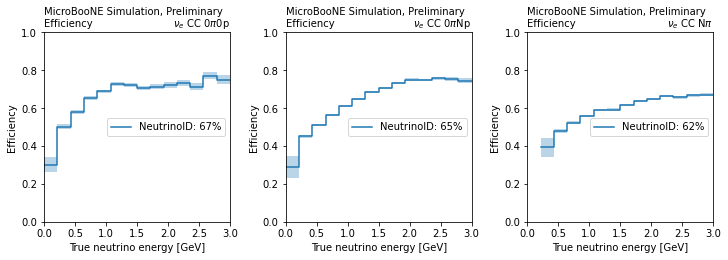

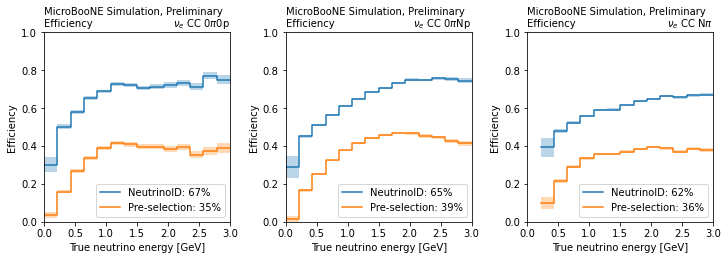

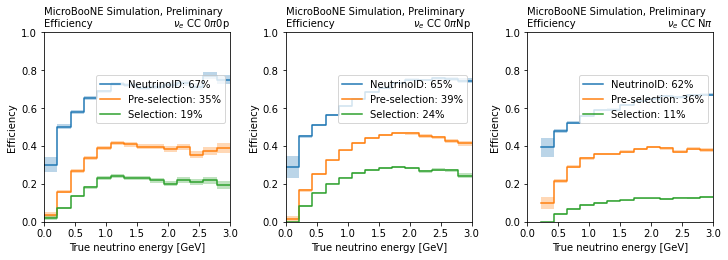

In [25]:
# eff per cat
cats = {1: 10, 2: 11, 3: 1}
x_min = 0
x_max = 3
n_bins = 15
selectors = ["daughter==0", "e_candidate & preselect", "e_candidate & select"]
labs = ["NeutrinoID", "Pre-selection", "Selection"]

for i in range(3):
    fig, axes = plt.subplots(ncols=3, figsize=(10, 3.5), constrained_layout=True)

    for cat, ax in zip(cats.keys(), axes):
        for selector, lab in zip(selectors[: (i + 1)], labs):
            num = nue_frame.query(selector).query("true_category==@cat")[field]
            den = nue_mc[field][nue_mc["true_category"] == cat]

            num_w = nue_frame.query(selector).query("true_category==@cat")[weight]
            den_w = nue_mc[weight][nue_mc["true_category"] == cat]

            eff, unc_low, unc_up, edges = plot_class.efficiency_post(
                num,
                den,
                num_w=num_w,
                den_w=den_w,
                n_bins=n_bins,
                x_min=x_min,
                x_max=x_max,
            )
            ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
            ax.step(
                edges,
                eff,
                where="post",
                label="{}: {:.0%}".format(lab, sum(num_w) / sum(den_w)),
            )
        ax.set_title(title + "\nEfficiency", loc="left")
        ax.set_title(plot_dicts_nue.category_labels[cats[cat]], loc="right")
        ax.set_xlabel("True neutrino energy [GeV]")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1)
        ax.set_xlim(x_min, x_max)
        if i == 0:
            ax.legend(loc="center right")
        elif i == 1:
            ax.legend(loc="lower right")
        else:
            ax.legend(loc="upper right", bbox_to_anchor=(1, 0.8))
    fig.savefig(output_dir + "efficiency_cat_{}.pdf".format(i), bbox_inches="tight")

NeutrinoID: 64.0%+-0.2%
num_w_h [ 0.44684798 14.730598   50.854897   76.37768    89.62329    94.08296
 91.03522    80.90381    74.01904    59.43921    51.625732   43.476746
 33.968628   25.532227  ]
den_w_h [  1.5023341  31.43393    97.668594  134.00748   147.10599   148.24078
 139.67578   121.5119    108.384155   86.48511    74.32001    62.44458
  48.713867   36.88611  ]
Pre-selection: 64.0%+-0.2%
num_w_h [ 0.44684798 14.730598   50.854897   76.37768    89.62329    94.08296
 91.03522    80.90381    74.01904    59.43921    51.625732   43.476746
 33.968628   25.532227  ]
den_w_h [  1.5023341  31.43393    97.668594  134.00748   147.10599   148.24078
 139.67578   121.5119    108.384155   86.48511    74.32001    62.44458
  48.713867   36.88611  ]
Pre-selection: 37.0%+-0.2%
num_w_h [4.6225656e-02 5.1002207e+00 2.4401087e+01 4.1910629e+01 5.3435196e+01
 5.8655930e+01 5.6199570e+01 4.9998611e+01 4.5981537e+01 3.6006592e+01
 3.0323364e+01 2.4835114e+01 1.9203003e+01 1.4242676e+01]
den_w_h [  1

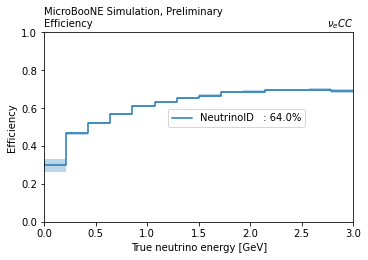

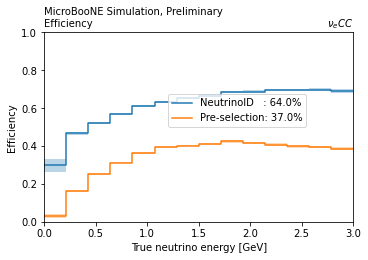

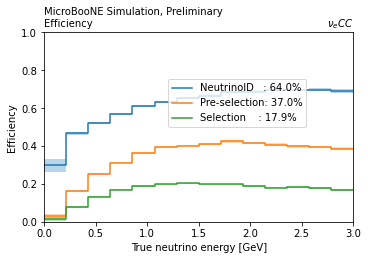

In [26]:
# eff total
x_min = 0
x_max = 3
n_bins = 15
selectors = ["daughter==0", "e_candidate & preselect", "e_candidate & select"]
labs = ["NeutrinoID", "Pre-selection", "Selection"]


for i in range(3):
    fig, ax = plt.subplots(ncols=1, figsize=(5, 3.5), constrained_layout=True)

    for selector, lab in zip(selectors[: (i + 1)], labs):
        num = nue_frame.query(selector)[field]
        den = nue_mc[field]

        num_w = nue_frame.query(selector)[weight]
        den_w = nue_mc[weight]
        
        print('{}: {:.1%}+-{:.1%}'.format(labs[i],*helper.effErr(num_w, den_w)))

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0:<13}: {1:0.1%}".format(lab, sum(num_w) / sum(den_w)),
        )
    ax.set_title(r"$\nu_e CC$", loc="right")
    ax.set_title(title + "\nEfficiency", loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc=(0.4,0.5))

    fig.savefig(output_dir + "efficiency_{}.pdf".format(i), bbox_inches="tight")

num_w_h [ 0.25424105 11.941861   33.684837   43.47549    44.600525   41.1792
 36.517258   28.534164   23.410233   17.595703   13.504395   10.812744
  7.8442383   5.2371826 ]
den_w_h [ 0.9553295 24.75369   62.406654  73.342606  70.43756   61.784515
 52.634186  40.083313  32.22339   23.34085   17.942078  14.381378
 10.359375   7.1983643]
num_w_h [1.5408552e-02 4.2065268e+00 1.6741541e+01 2.4408888e+01 2.7378307e+01
 2.6322632e+01 2.3209534e+01 1.8054428e+01 1.4517517e+01 1.0965195e+01
 8.1217957e+00 6.2107849e+00 4.2150116e+00 2.8356934e+00]
den_w_h [ 0.9553295 24.75369   62.406654  73.342606  70.43756   61.784515
 52.634186  40.083313  32.22339   23.34085   17.942078  14.381378
 10.359375   7.1983643]
num_w_h [7.7042761e-03 2.1109684e+00 1.0077430e+01 1.5423441e+01 1.7198011e+01
 1.6798401e+01 1.4910503e+01 1.1612473e+01 9.1851807e+00 6.6654205e+00
 4.9701691e+00 4.0377808e+00 2.8125763e+00 1.6259003e+00]
den_w_h [ 0.9553295 24.75369   62.406654  73.342606  70.43756   61.784515
 52.6341

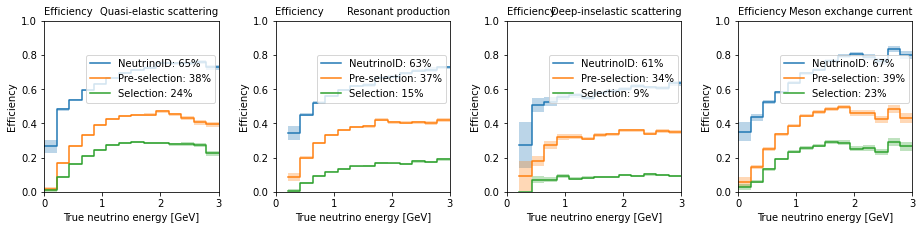

In [27]:
# eff per mode
cats = [0, 1, 2, 10]
fig, axes = plt.subplots(ncols=4, figsize=(13, 3.3))

for cat, ax in zip(cats, axes):
    for selector, lab in zip(selectors, labs):
        num = nue_frame.query(selector).query("interaction==@cat & true_category>0")[
            field
        ]
        den = nue_mc[field][
            (nue_mc["interaction"] == cat) & (nue_mc["true_category"] > 0)
        ]

        num_w = nue_frame.query(selector).query("interaction==@cat & true_category>0")[
            weight
        ]
        den_w = nue_mc[weight][
            (nue_mc["interaction"] == cat) & (nue_mc["true_category"] > 0)
        ]

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{}: {:.0f}%".format(lab, sum(num_w) / sum(den_w) * 100),
        )
    ax.set_title(plot_dicts_nue.int_labels[cat], loc="right")
    ax.set_title("Efficiency", loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc=(0.24,0.522))

fig.tight_layout()
fig.savefig(output_dir + "efficiency_int.pdf", bbox_inches="tight")

In [28]:
daughters = nue_frame.query("e_candidate & preselect").query(
    "abs(backtracked_pdg)==11 & true_category>0 "
)

cols = ["backtracked_px", "backtracked_py", "backtracked_pz"]
daughters["backtracked_theta"], daughters["backtracked_phi"] = cosmic_angles(
    *daughters[cols].T.values
)

In [29]:
daughters["shr_energy_y_v"].describe()

count    60455.000000
mean       927.303406
std        594.177490
min        100.021805
25%        485.164780
50%        795.663635
75%       1218.181519
max       4953.538574
Name: shr_energy_y_v, dtype: float64

In [30]:
daughters["e_reco_y"] = daughters["shr_energy_y_v"] / 1000
daughters = daughters.clip(-4, 300)

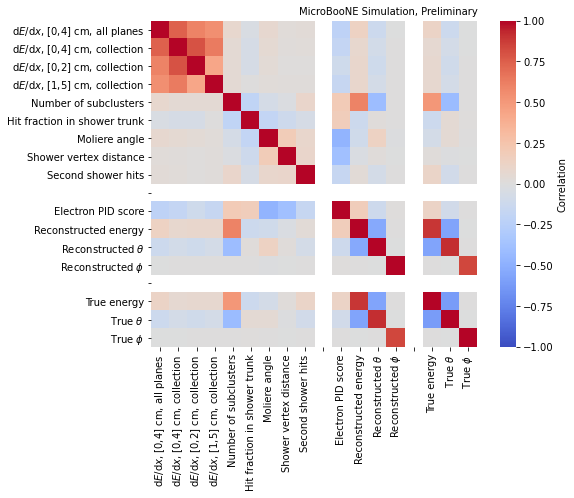

In [31]:
columns_map = [
    "shr_tkfit_4cm_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_2cm_dedx_Y",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_subclusters_v",
    "shr_tkfit_hitratio_v",
    "shr_moliere_avg_v",
    "shr_dist_v",
    "secondshower_Y_nhit",
    "",
    "score",
    "e_reco_y",
    "shr_theta_v",
    "shr_phi_v",
    "",
    "backtracked_e",
    "backtracked_theta",
    "backtracked_phi",
]

map_labels = [
    r"d$E/$d$x$, [0,4] cm, all planes",
    r"d$E/$d$x$, [0,4] cm, collection",
    r"d$E/$d$x$, [0,2] cm, collection",
    r"d$E/$d$x$, [1,5] cm, collection",
    "Number of subclusters",
    "Hit fraction in shower trunk",
    "Moliere angle",
    "Shower vertex distance",
    "Second shower hits",
    "",
    "Electron PID score",
    "Reconstructed energy",
    r"Reconstructed $\theta$",
    r"Reconstructed $\phi$",
    "",
    "True energy",
    r"True $\theta$",
    r"True $\phi$",
]

daughters[""] = 0

plt.subplots(figsize=(8, 6))
sns.heatmap(
    daughters[columns_map].corr(),
    cmap="coolwarm",
    xticklabels=map_labels,
    yticklabels=map_labels,
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlation"},
    square=True,
)
plt.title(title, loc="right")
plt.savefig(output_dir + "e_cand_corr.pdf", bbox_inches="tight")


Energy
0.1 	 0.14931494 	 [-0.0009198   0.02082144  0.09482575] 	 0.04787277923561632
0.2 	 0.21453348 	 [-0.04361464  0.00980711  0.05626438] 	 0.049939511232078064
0.3 	 0.29474637 	 [-0.08659564 -0.00214806  0.05165959] 	 0.06912761527821422
0.4 	 0.38411832 	 [-0.12137685 -0.0113548   0.05601471] 	 0.08869578137397766
0.5 	 0.4709169 	 [-0.16483099 -0.02619496  0.059966  ] 	 0.1123984914958477
0.6 	 0.5648213 	 [-0.19513006 -0.03460455  0.06897062] 	 0.13205034196972842
0.7 	 0.654574 	 [-0.23476522 -0.0447458   0.07396093] 	 0.1543630756139755
0.8 	 0.74807537 	 [-0.26288413 -0.0511775   0.07771003] 	 0.17029707839563485
0.9 	 0.82611215 	 [-0.30503726 -0.06999823  0.07078767] 	 0.18791246213912963
1.0 	 0.9243845 	 [-0.32798525 -0.07347652  0.07591198] 	 0.20194861511439083
1.1 	 1.0070918 	 [-0.35718151 -0.0890789   0.07397762] 	 0.2155795657634735
1.2 	 1.0896542 	 [-0.4012074  -0.10532153  0.07333367] 	 0.23727053792774677
1.3 	 1.1726952 	 [-0.44658164 -0.12628365  0.0707880

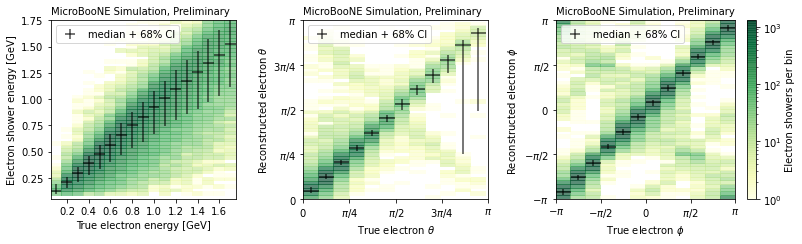

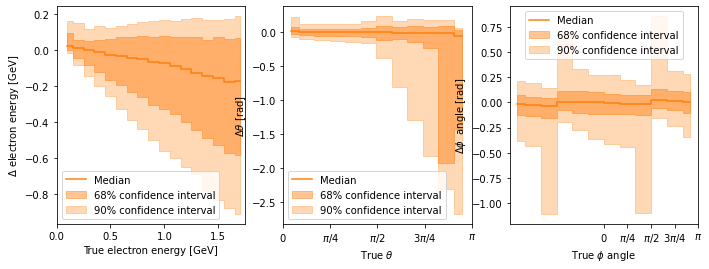

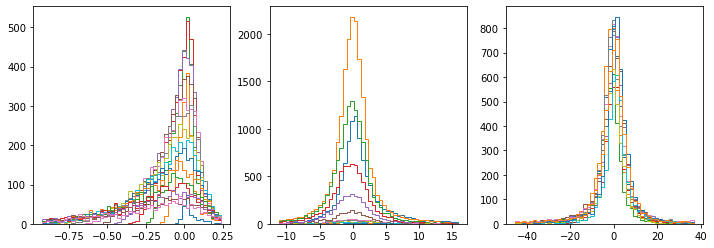

In [32]:
fig, ax = plt.subplots(
    ncols=3, figsize=(11.2, 3.5), gridspec_kw={"width_ratios": [4, 4, 4.85]}
)

fig_res, ax_res = plt.subplots(ncols=3, figsize=(11.5, 4))
fig2, ax2 = plt.subplots(ncols=3, figsize=(12, 4))
n_x = 17
n_y = 50

print("\nEnergy")
y_min = 0.05
y_max = 1.75
fld_mc = "backtracked_e"
fld_reco = "e_reco_y"
h, x_edges, y_edges, im = ax[0].hist2d(
    daughters.eval(fld_mc),
    daughters.eval(fld_reco),
    cmap="YlGn",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((y_min, y_max), (y_min, y_max)),
)
ax[0].set_xlabel("True electron energy [GeV]")
ax[0].set_ylabel("Electron shower energy [GeV]")
mids, mean, err, quants = getResolution(
    daughters.eval(fld_mc), daughters.eval(fld_reco), x_edges, ax2[0]
)
ax[0].set_xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6])
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")
ax[0].set_title(title, loc="left")

ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("True electron energy [GeV]")
ax_res[0].set_ylabel(r"$\Delta$ electron energy [GeV]")
ax_res[0].set_xlim(0, y_max)
ax_res[0].legend()

print("\nTheta")
n_x = 12
fld_mc, fld_reco = "backtracked_theta", "shr_theta_v"
h, x_edges, y_edges, im = ax[1].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="YlGn",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[1].set_xticks(helper.theta_ticks)
ax[1].set_xticklabels(helper.theta_labs)
ax[1].set_yticks(helper.theta_ticks)
ax[1].set_yticklabels(helper.theta_labs)
ax[1].set_xlabel(r"True electron $\theta$")
ax[1].set_ylabel(r"Reconstructed electron $\theta$")
ax[1].set_ylim(0, np.pi)
ax[1].set_title(title, loc="left")
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[1], periodic=True
)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")


ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xticks(helper.theta_ticks)
ax_res[1].set_xticklabels(helper.theta_labs)
ax_res[1].set_xlabel(r"True $\theta$")
ax_res[1].set_ylabel(r"$\Delta \theta$ [rad]")
ax_res[1].set_xlim(0, np.pi)
ax_res[1].legend()

print("\nPhi")
n_x = 12
fld_mc, fld_reco = "backtracked_phi", "shr_phi_v"
h, x_edges, y_edges, im = ax[2].hist2d(
    daughters[fld_mc],
    daughters[fld_reco],
    cmap="YlGn",
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[2].set_xticks(helper.phi_ticks)
ax[2].set_xticklabels(helper.phi_labs)
ax[2].set_yticks(helper.phi_ticks)
ax[2].set_yticklabels(helper.phi_labs)
ax[2].set_xlabel(r"True electron $\phi$")
ax[2].set_ylabel(r"Reconstructed electron $\phi$")
ax[2].set_ylim(-np.pi, np.pi)
mids, mean, err, quants = getResolution(
    daughters[fld_mc], daughters[fld_reco], x_edges, ax2[2], periodic=True
)
ax[2].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[2].legend(loc="upper left")
ax[2].set_title(title, loc="left")

ax_res[2].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[2].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[2].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[2].set_xticks(helper.theta_ticks)
ax_res[2].set_xticklabels(helper.theta_labs)
ax_res[2].set_xlabel(r"True $\phi$ angle")
ax_res[2].set_ylabel(r"$\Delta \phi$  angle [rad]")
ax_res[2].set_xlim(-np.pi, np.pi)
ax_res[2].legend(loc="upper center")


#[ax_i.set_aspect("equal") for ax_i in ax]

clb = fig.colorbar(im, ax=ax[2])
clb.set_label("Electron showers per bin", rotation=90)
fig.tight_layout()
fig.savefig(output_dir + "electron_resolution.pdf")

num_w_h [   68.04853  4912.4624  15421.515   26744.31    30028.492   26561.305
 19278.594   11095.961    5374.828  ]
den_w_h [   81.09935  5572.6724  17428.438   30023.514   33703.973   29987.703
 21956.148   12875.016    6358.2812 ]
num_w_h [   36.09249  3849.8906  12759.64    22173.193   25512.719   23016.84
 16950.703    9866.797    4899.0156 ]
den_w_h [   81.09935  5572.6724  17428.438   30023.514   33703.973   29987.703
 21956.148   12875.016    6358.2812 ]
num_w_h [   33.40446  3591.2515  12000.803   20766.799   23763.328   21230.164
 15446.273    8850.227    4315.625  ]
den_w_h [   81.09935  5572.6724  17428.438   30023.514   33703.973   29987.703
 21956.148   12875.016    6358.2812 ]


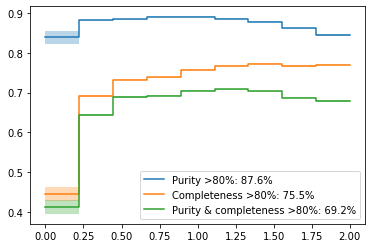

In [33]:
fig, ax = plt.subplots()

x_min = 0
x_max = 2.0
n_bins = 10

q_arr = [
    "nu_purity_from_pfp>0.8",
    "nu_completeness_from_pfp>0.8",
    "(nu_purity_from_pfp>0.8)*(nu_completeness_from_pfp>0.8)",
]
lab_arr = ["Purity >80%", "Completeness >80%", "Purity & completeness >80%"]
q_den = nu_mc.query("(true_category>0)*(n_pfps>0)")
nu_e_dv = q_den["nu_e"]
nu_e_dw = q_den[weight]
for q, l in zip(q_arr, lab_arr):
    nu_e_q = q_den.query(q)["nu_e"]
    w_q = q_den.query(q)[weight]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        nu_e_q,
        nu_e_dv,
        num_w=w_q,
        den_w=nu_e_dw,
        n_bins=n_bins,
        x_min=x_min,
        x_max=x_max,
    )

    ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax.step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.1%}".format(l, sum(w_q) / sum(nu_e_dw)),
    )
ax.legend()